<a href="https://colab.research.google.com/github/jiwonlydia/ReturnPrediction/blob/main/0525_catboost%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
path = '/content/drive/MyDrive/송교수님 weekly meeting/return_prediction/Empirical Asset Pricing Via Machine Learning/char60_1996_2021'
os.chdir(path)

In [3]:
# !pip install catboost

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import pyarrow.feather as feather
# import wrds
# from functions import *
from pandas.tseries.offsets import *
from refit_model import *
from preprocess import *
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
## display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_seq_items', None)

In [5]:
raw1990 = pd.read_csv('chars60_raw_1990s.csv')
raw2000 = pd.read_csv('chars60_raw_2000s.csv')
raw2010 = pd.read_csv('chars60_raw_2010s.csv')
raw2020 = pd.read_csv('chars60_raw_2020s.csv')
raw = pd.concat([raw1990, raw2000, raw2010, raw2020], axis=0)
raw['date'] = pd.to_datetime(raw['date'])
raw['month'] = raw['date'].dt.month
raw.shape

(983811, 59)

In [9]:
macro = pd.read_csv('2_Macroeconomic Variables.csv')
macro['date'] = pd.to_datetime(macro['date'])

macro['year'] = macro['date'].dt.year
macro['month'] = macro['date'].dt.month

macro.head(2)

# macro = macro[macro['date'] >= '1995-08-01'] # x_frames=5인 경우

,date,RPI,W875RX1,DPCERA3M086SBEA,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,PERMIT,PERMITNE,PERMITMW,PERMITS,PERMITW,M1SL,M2SL,M2REAL,AMBSL,TOTRESNS,NONBORRES,BUSLOANS,REALLN,FEDFUNDS,NONREVSL,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,WPSFD49207,WPSFD49502,WPSID61,WPSID62,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,CMRMTSPL,ISRATIO,AMDMUO,BUSINV,EXSZUS,EXJPUS,EXUSUK,EXCAUS,Index,D12,E12,b/m,tbl,lty,ntis,Rfree,infl,ltr,corpr,svar,S&P 500,EWPRET,VWPRET,year,month
0,1995-01-01,8652.0,7430.4,62.0,73.4,80.2,77.5,92.4,87.8,95.0,51.4,66.0,46.5,108.0,73.5,79.6,74.4,84.5,132038,124663,5.6,17.1,2764,2164,2396,1056,1340,116501,23147,568.2,5234,17262,10326,6936,93354,23624,5333.7,13814.1,6859,19397,41.3,5.2,41.8,1407,127,289,656,335,1282,139,285,567,291,1151.4,3492.4,2320.5,437.4,60.5,60400,654.4,996.8,5.5,638.4,5.7,6.2,7.1,7.8,7.8,8.5,9.1,0.2,0.7,1.5,2.2,2.3,2.9,3.6,126.9,124.6,122.8,102.1,158.3,150.5,132.2,137.4,216.6,135.4,126.9,166.0,151.2,147.0,146.8,71.1,140.1,67.2,63.6,12.8,14.4,12.2,2889.7,71027.0,250195.4,890.1,884976.2,1.5,432805,935639,1.3,99.8,1.6,1.4,470.42,13.17,31.25,0.290854,0.0571,0.0780,0.015093,0.0042,0.004008,0.0273,0.0256,0.000289,0.0260,0.0234,0.0270,1995,1
1,1995-02-01,8671.6,7446.1,61.8,73.3,80.1,77.5,92.6,87.3,95.4,51.4,65.8,46.5,107.2,73.3,82.3,74.4,83.9,132115,124928,5.4,17.0,2578,2197,2345,1119,1226,116697,23103,563.5,5192,17265,10348,6917,93594,23688,5357.7,13850.6,6850,19407,40.9,5.0,41.7,1316,130,285,564,337,1254,112,274,536,332,1147.4,3489.9,2312.7,438.5,57.7,57600,666.6,1006.2,5.9,640.5,5.8,6.0,6.7,7.4,7.5,8.3,8.9,-0.2,0.1,0.8,1.5,1.6,2.3,2.9,127.2,124.9,123.7,102.9,160.1,150.9,131.9,137.9,217.4,135.6,127.4,166.5,151.6,147.4,147.1,71.3,140.1,67.2,63.8,12.8,14.6,12.2,2863.3,69931.0,249872.0,875.1,879996.8,1.5,434001,942713,1.3,98.2,1.6,1.4,487.39,13.17,31.90,0.278730,0.0577,0.0758,0.014532,0.0040,0.003992,0.0287,0.0289,0.000472,0.0392,0.0485,0.0425,1995,2


In [8]:
# train test split
train_set = macro[macro['date'].dt.year < 2012]
val_set = macro[(macro['date'].dt.year >= 2012)&(macro['date'].dt.year < 2017)]

full_train_set = macro[macro['date'].dt.year < 2017]
test_set = macro[macro['date'].dt.year >= 2017]

In [37]:
features = ['b/m']

In [38]:
x_frames=12
trainX, trainY = build_timeseries(data=train_set, features=features, x_frames=12, y_frames=1)
valX, valY = build_timeseries(data=val_set, features=features, x_frames=12, y_frames=1)
testX, testY = build_timeseries(data=test_set, features=features, x_frames=12, y_frames=1)

print(f'trainX shape: {trainX.shape}, trainY shape: {trainY.shape}')
print(f'valX shape: {valX.shape}, valY shape: {valY.shape}')

# print(f'full_trainX shape: {full_trainX.shape}, full_trainY shape: {full_trainY.shape}')
print(f'testX shape: {testX.shape}, testY shape: {testY.shape}')

trainX shape: (191, 12, 1), trainY shape: (191, 1, 1)
valX shape: (47, 12, 1), valY shape: (47, 1, 1)
testX shape: (23, 12, 1), testY shape: (23, 1, 1)


In [15]:
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model

inputs = Input(shape=(trainX.shape[1],trainX.shape[2]))
lstm_layer = LSTM(10)(inputs)
x = Dense(10, activation='relu')(lstm_layer)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)

In [16]:
model.compile(loss='mse', optimizer='adam')

In [17]:
history = model.fit(trainX,
                   trainY,
                    epochs=50,
                    batch_size=30,
                    validation_data = (valX,valY)
                    )

Epoch 1/50
7/7 [==============================] - 3s 99ms/step - loss: 0.0634 - val_loss: 0.0228
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0573 - val_loss: 0.0184
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0517 - val_loss: 0.0146
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0459 - val_loss: 0.0109
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0400 - val_loss: 0.0071
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0334 - val_loss: 0.0036
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0266 - val_loss: 0.0010
Epoch 8/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0196 - val_loss: 2.4475e-04
Epoch 9/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0136 - val_loss: 0.0024
Epoch 10/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 11/50
7/7 [========

In [18]:
# 예측
pred = model.predict(testX)

In [27]:
pred.shape

(23, 1)

In [32]:
test_set[x_frames:-1].shape

(23, 128)

In [35]:
temp[features]

,b/m
276,0.222519
277,0.232478
278,0.247354
279,0.246739
280,0.244185
281,0.245638
282,0.234584
283,0.229618
284,0.225335
285,0.237380


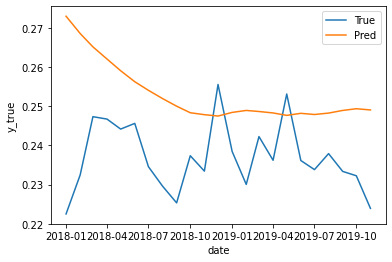

In [34]:
temp = test_set[x_frames:-1].copy()
temp['y_pred'] = pred
temp['y_true'] = temp[features]
g = sns.lineplot(data=temp, x='date', y='y_true', ci=None,
                label='True')
g = sns.lineplot(data=temp, x='date', y='y_pred', ci=None, label='Pred')


In [117]:
lstm_features = [s+'_lstm' for s in features]
lstm_features

['b/m_lstm', 'tbl_lstm', 'lty_lstm', 'ntis_lstm', 'svar_lstm']

In [137]:
# trainX.shape
full_train_macro = full_train_set[full_train_set['date']>='1996-01-01'][:macro_lstm.shape[0]]
full_train_macro[lstm_features] = macro_lstm

In [138]:
full_train_macro = full_train_macro.drop(['date']+features, axis=1)
full_train_macro.head(3)

,year,month,b/m_lstm,tbl_lstm,lty_lstm,ntis_lstm,svar_lstm
12,1996,1,0.488069,0.425402,0.547761,0.656261,0.021733
13,1996,2,0.485501,0.419971,0.544640,0.659276,0.024108
14,1996,3,0.492064,0.418568,0.551963,0.665113,0.023450


In [139]:
# 연도별로 시총 top 500에 드는 회사만을 데이터셋에 포함시킨다
df500 = pd.DataFrame()
for year in range(1996, 2017):
    temp = raw[raw['date'].dt.year == year]
    top500_list = temp.groupby('permno').mean()[['me']].reset_index().\
                sort_values(by='me', ascending=False)[:500]['permno'].tolist()
    df500 = pd.concat([df500, temp[temp['permno'].isin(top500_list)]], axis=0)

In [140]:
df500.head(3)

,ticker,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,me_ia,ill,maxret,mom12m,mom1m,mom36m,mom60m,mom6m,std_dolvol,me,dy,cinvest,nincr,pscore,acc,bm,agr,alm,ato,cash,cashdebt,cfp,chcsho,chpm,chtx,depr,ep,gma,grltnoa,lev,lgr,ni,noa,op,pctacc,pm,rd_sale,rdm,rna,roa,roe,rsup,sgr,sp,date,ffi49,year,month
504,ABCR,29395,79932,3460,0.003155,3.0,11.0,0.000019,0.718142,0.627380,0.0,1.583500,285.419267,0.061069,0.227887,0.309917,1.710355,0.500753,-0.304598,1.498443,1.659495e+05,0.000000,0.167100,1.0,1.0,-0.028864,0.000410,-0.164155,0.000627,0.203573,0.000000,-0.043146,0.000107,0.000000,-0.005772,-0.001794,0.145995,0.000041,0.267612,1.021303,0.000647,-0.241566,0.000000,30.073630,0.360685,-4.986288,0.121471,0.003330,2.054353e-06,-0.013413,0.003248,0.008817,-0.000571,-0.354647,0.001450,1996-12-31,20,1996,12
874,ABRX,30248,80499,6411,-0.084302,3.0,11.0,0.000022,0.686752,0.758923,0.0,1.737907,279.023490,0.114046,0.227887,-0.379061,1.710355,0.500753,0.103586,0.870830,5.858750e+05,0.000000,0.541123,2.0,1.0,-0.008732,0.000311,-0.164155,0.000313,0.203573,0.795754,-0.043146,0.000012,0.000000,-0.005772,-0.001794,0.106396,0.000010,0.267612,1.021303,0.000037,-0.241566,0.000000,30.073630,0.044648,-4.986288,0.230346,0.003049,1.621506e-07,-0.013413,0.011180,0.012406,-0.000571,-0.354647,0.000053,1996-12-31,46,1996,12
905,ABS,1240,50032,5411,0.037618,1.0,11.0,0.000050,0.152086,0.166553,0.0,5.379486,127.408128,0.043321,0.291509,0.039610,1.213907,0.724363,0.857143,0.380656,1.004567e+07,0.000013,-0.006602,0.0,1.0,0.000778,0.000195,0.014945,0.000239,0.313116,0.016710,0.148454,0.000071,0.011193,0.010631,0.006720,0.093217,0.000046,0.245745,1.261199,0.000217,-0.068845,0.011131,1102.803205,0.509476,0.068929,0.078880,0.000000,0.000000e+00,0.033414,0.015854,0.036729,0.000093,0.566609,0.001253,1996-06-30,43,1996,6


In [141]:
df500_macro = pd.merge(df500, full_train_macro, on=['year','month'], how='left')

In [142]:
display(df500_macro.head(3))
display(df500_macro.tail(3))

,ticker,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,me_ia,ill,maxret,mom12m,mom1m,mom36m,mom60m,mom6m,std_dolvol,me,dy,cinvest,nincr,pscore,acc,bm,agr,alm,ato,cash,cashdebt,cfp,chcsho,chpm,chtx,depr,ep,gma,grltnoa,lev,lgr,ni,noa,op,pctacc,pm,rd_sale,rdm,rna,roa,roe,rsup,sgr,sp,date,ffi49,year,month,b/m_lstm,tbl_lstm,lty_lstm,ntis_lstm,svar_lstm
0,ABCR,29395,79932,3460,0.003155,3.0,11.0,0.000019,0.718142,0.627380,0.0,1.583500,285.419267,0.061069,0.227887,0.309917,1.710355,0.500753,-0.304598,1.498443,1.659495e+05,0.000000,0.167100,1.0,1.0,-0.028864,0.000410,-0.164155,0.000627,0.203573,0.000000,-0.043146,0.000107,0.000000,-0.005772,-0.001794,0.145995,0.000041,0.267612,1.021303,0.000647,-0.241566,0.000000,30.073630,0.360685,-4.986288,0.121471,0.003330,2.054353e-06,-0.013413,0.003248,0.008817,-0.000571,-0.354647,0.001450,1996-12-31,20,1996,12,0.498883,0.409795,0.559247,0.678264,0.025316
1,ABRX,30248,80499,6411,-0.084302,3.0,11.0,0.000022,0.686752,0.758923,0.0,1.737907,279.023490,0.114046,0.227887,-0.379061,1.710355,0.500753,0.103586,0.870830,5.858750e+05,0.000000,0.541123,2.0,1.0,-0.008732,0.000311,-0.164155,0.000313,0.203573,0.795754,-0.043146,0.000012,0.000000,-0.005772,-0.001794,0.106396,0.000010,0.267612,1.021303,0.000037,-0.241566,0.000000,30.073630,0.044648,-4.986288,0.230346,0.003049,1.621506e-07,-0.013413,0.011180,0.012406,-0.000571,-0.354647,0.000053,1996-12-31,46,1996,12,0.498883,0.409795,0.559247,0.678264,0.025316
2,ABS,1240,50032,5411,0.037618,1.0,11.0,0.000050,0.152086,0.166553,0.0,5.379486,127.408128,0.043321,0.291509,0.039610,1.213907,0.724363,0.857143,0.380656,1.004567e+07,0.000013,-0.006602,0.0,1.0,0.000778,0.000195,0.014945,0.000239,0.313116,0.016710,0.148454,0.000071,0.011193,0.010631,0.006720,0.093217,0.000046,0.245745,1.261199,0.000217,-0.068845,0.011131,1102.803205,0.509476,0.068929,0.078880,0.000000,0.000000e+00,0.033414,0.015854,0.036729,0.000093,0.566609,0.001253,1996-06-30,43,1996,6,0.513298,0.420050,0.575903,0.679330,0.019141


,ticker,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,me_ia,ill,maxret,mom12m,mom1m,mom36m,mom60m,mom6m,std_dolvol,me,dy,cinvest,nincr,pscore,acc,bm,agr,alm,ato,cash,cashdebt,cfp,chcsho,chpm,chtx,depr,ep,gma,grltnoa,lev,lgr,ni,noa,op,pctacc,pm,rd_sale,rdm,rna,roa,roe,rsup,sgr,sp,date,ffi49,year,month,b/m_lstm,tbl_lstm,lty_lstm,ntis_lstm,svar_lstm
116285,ZTS,13721,13788,2834,-0.080946,1.0,11.0,0.000004,0.100415,0.101481,-0.1,3.965216,533.035537,0.029968,0.250858,0.017808,0.682051,0.450437,0.157359,0.353313,2.574724e+07,0.000007,0.007145,1.0,5.0,0.028293,0.000056,0.159098,0.000103,0.199142,0.090568,0.102713,0.000023,-0.007896,0.007167,0.009798,0.157175,0.000015,0.515863,0.764676,0.000243,0.222634,-0.007928,6777.022706,0.926988,1.074074,0.318221,0.077542,0.000015,0.063371,0.025780,0.191011,0.000002,0.005808,0.000188,2016-10-31,13,2016,10,0.387933,0.345405,0.432502,0.619431,0.070221
116286,ZTS,13721,13788,2834,0.055962,1.0,11.0,0.000004,0.109259,0.101481,-0.1,3.644248,659.942020,0.029968,0.218964,-0.080946,0.679357,0.367239,0.108103,0.354690,2.366310e+07,0.000007,0.013832,2.0,6.0,0.033050,0.000070,0.139436,0.000113,0.200391,0.087523,0.147968,0.000036,-0.007908,0.052988,0.015005,0.160328,0.000027,0.509700,0.770190,0.000260,0.139177,-0.007940,6859.066838,1.035461,0.852895,0.307502,0.077459,0.000016,0.061621,0.030055,0.192275,0.000001,0.008473,0.000206,2016-11-30,13,2016,11,0.395139,0.347379,0.440685,0.623098,0.068228
116287,ZTS,13721,13788,2834,0.062525,1.0,11.0,0.000004,0.103918,0.101481,-0.1,3.831550,855.414572,0.060529,0.029943,0.055962,0.568689,0.680097,0.010031,0.442689,2.487931e+07,0.000007,0.013832,2.0,6.0,0.033050,0.000066,0.139436,0.000107,0.200391,0.087523,0.147968,0.000034,-0.007908,0.052988,0.015005,0.160328,0.000026,0.509700,0.770190,0.000247,0.139177,-0.007940,6859.066838,1.035461,0.852895,0.307502,0.077459,0.000015,0.061621,0.030055,0.192275,0.000001,0.008473,0.000196,2016-12-31,13,2016,12,NaN,NaN,NaN,NaN,NaN


In [143]:
df = df500_macro.copy()
features = df.columns.drop(['date','gvkey','permno','sic','ret','ticker','month']).tolist()
print(features)

['exchcd', 'shrcd', 'adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 'std_dolvol', 'me', 'dy', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'ffi49', 'year', 'b/m_lstm', 'tbl_lstm', 'lty_lstm', 'ntis_lstm', 'svar_lstm']


In [145]:
macro_lstm_r2 = refit_catboost(df, features, train_start=1996, train_end=2011, valid_size=5)

train:  1996 2011
valid:  2012


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0427
train:  1996 2012
valid:  2013
0.1094
train:  1996 2013
valid:  2014
0.0452
train:  1996 2014
valid:  2015
-0.0174
train:  1996 2015
valid:  2016
0.033
[0.0427, 0.1094, 0.0452, -0.0174, 0.033]


In [ ]:
r2 = refit_catboost(df, features, train_start=1996, train_end=2011, valid_size=5)

train:  1996 2011
valid:  2012
0.0612
train:  1996 2012
valid:  2013
0.1874
train:  1996 2013
valid:  2014
0.0339
train:  1996 2014
valid:  2015
0.0019
train:  1996 2015
valid:  2016
0.0552
[0.0612, 0.1874, 0.0339, 0.0019, 0.0552]


In [ ]:
r2

0.06792000000000001

In [ ]:
train_set = df[df['year']<2017]
test_set = df[df['year']>=2017]
X_train, y_train = train_set[features], np.array(train_set['ret'])
X_test, y_test = test_set[features], np.array(test_set['ret'])

cat_features = ['exchcd','shrcd','ffi49']
for data in [X_train, X_test]:
    data[cat_features] = data[cat_features].astype(str)

# train, valid 합친 전체 데이터로 fit
cat_model = CatBoostRegressor(
    cat_features=cat_features,
    verbose = False, eval_metric="RMSE"
)

cat_fit = cat_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# performance on test set
cat_pred = cat_fit.predict(X_test)

cat_r2 = r2_oos(y_test, cat_pred) ; print(cat_r2)

In [ ]:
def plot_predictions(test_set, y_pred, num_samples, seed=None):
    import random
    random.seed(seed)
    
    data = test_set.copy()
    data['y_pred'] = y_pred
    unq_list = random.sample(data['permno'].unique().tolist(), num_samples)
    
    f, ax = plt.subplots(nrows=num_samples, ncols=1, figsize=(10, num_samples*3))    
    for i, p in enumerate(unq_list):
        temp = data[data['permno']==p]
        tic = temp['ticker'].values[0]
        g = sns.lineplot(data=temp, x='date', y='ret', ci=None, ax=ax[i],
                        label='True')
        g = sns.lineplot(data=temp, x='date', y='y_pred', ci=None, ax=ax[i],
                        label='Pred')
        g.set_title(f'permno : {p} / ticker : {tic}')
#         g.set_ylim(-.1, .1)
        g.set_xlim(data['date'].min(), data['date'].max())
        plt.tight_layout()


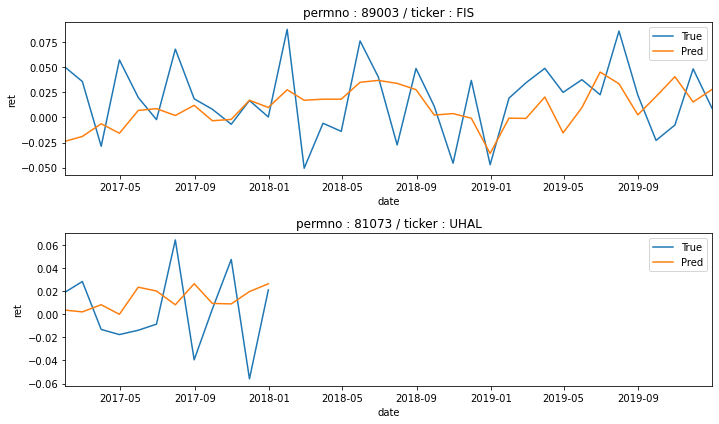

In [ ]:
plot_predictions(test_set, cat_pred, num_samples=2)